In [47]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
import pandas as pd
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import Point

import rasterio
import tables as tab
import tqdm.notebook as tqdm
from skimage.transform import  AffineTransform
from rasterio.transform import Affine
from skimage.measure import ransac
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, SIFT
from PIL import Image
import re
import math, requests
import io
import tqdm
import sys



from PRISMA_georeference import adjust_lat_lon, GoogleMapDownloader, GoogleMapsLayers, pixel_to_latlon, latlon_to_pix, prisma_2_tiff, match_subblocks

In [48]:
dir_path = r"C:\Users\simon\Documents\Skole\EIT\Tare_Naturbase"

In [49]:
filename = "HyperSpectral4.he5"

filename = dir_path + "/" + filename


with h5py.File(filename, mode='r') as f:
    # List available datasets.
    print(f.keys())
    print(type(f["HDFEOS INFORMATION"]))
    dset = f["HDFEOS"]
    print(dset.keys())

    info = f["Info"]["Ancillary"]
    print(info.keys())
    
    dataset = dset["SWATHS"]
    #dataset_L1 = dataset["PRS_L1_HCO"]["Geolocation Fields"]["Latitude_SWIR"]
    dataset_L1 = dataset["PRS_L1_HCO"]["Geolocation Fields"]

    print(dataset.keys())
    print(dataset_L1.keys())
    print(dataset_L1["Latitude_SWIR"][0:10])

<KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION', 'Info', 'KDP_AUX']>
<class 'h5py._hl.group.Group'>
<KeysViewHDF5 ['ADDITIONAL', 'SWATHS']>
<KeysViewHDF5 ['GyroData', 'PVSdata', 'StarTracker1', 'StarTracker2']>
<KeysViewHDF5 ['PRS_L1_HCO', 'PRS_L1_HRC', 'PRS_L1_PCO', 'PRS_L1_PRC']>
<KeysViewHDF5 ['Latitude_SWIR', 'Latitude_VNIR', 'Longitude_SWIR', 'Longitude_VNIR', 'Time']>
[[62.057938 62.057682 62.05743  ... 61.805214 61.80496  61.804707]
 [62.058025 62.057774 62.057518 ... 61.8053   61.805046 61.804794]
 [62.058117 62.05786  62.05761  ... 61.80539  61.805138 61.804882]
 ...
 [62.05856  62.058308 62.058052 ... 61.805832 61.80558  61.805325]
 [62.05865  62.058395 62.058144 ... 61.80592  61.805668 61.805412]
 [62.05874  62.058483 62.05823  ... 61.806007 61.805756 61.805504]]


In [50]:

with h5py.File(filename, mode='r') as f:
    print(f"Keys: {f.keys()}")
    for key in f.keys():
        print(key)
        print(f[key].keys())
    print(f["KDP_AUX"]["LOS_Pan"][0])

    print(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]["Data Fields"].keys())
    print(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]["Geolocation Fields"].keys())

Keys: <KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION', 'Info', 'KDP_AUX']>
HDFEOS
<KeysViewHDF5 ['ADDITIONAL', 'SWATHS']>
HDFEOS INFORMATION
<KeysViewHDF5 ['StructMetadata.0']>
Info
<KeysViewHDF5 ['Ancillary', 'Header', 'Housekeeping']>
KDP_AUX
<KeysViewHDF5 ['Cw_Swir_Matrix', 'Cw_Vnir_Matrix', 'Fwhm_Swir_Matrix', 'Fwhm_Vnir_Matrix', 'LOS_Pan', 'LOS_Swir', 'LOS_Vnir']>
[ 0.337853   -0.03228952  0.9406448 ]
<KeysViewHDF5 ['FrameNumber', 'SWIR_Cube', 'SWIR_PIXEL_SAT_ERR_MATRIX', 'VNIR_Cube', 'VNIR_PIXEL_SAT_ERR_MATRIX']>
<KeysViewHDF5 ['Latitude_SWIR', 'Latitude_VNIR', 'Longitude_SWIR', 'Longitude_VNIR', 'Time']>


In [51]:
with h5py.File(filename, mode='r') as f:
    data = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]["Data Fields"]['VNIR_Cube'])
    lat = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]['Geolocation Fields']['Latitude_VNIR'])
    lon = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]['Geolocation Fields']['Longitude_VNIR'])

In [71]:
coord = np.array([lat,lon]).T
coord.shape

adjusted = np.load('out/out4.npy')
adjusted.shape



(1000, 1000, 2)

In [72]:
data_with_coord = np.zeros((1000,1000,66+2))

In [73]:
data_with_coord[:,:,:66] = np.transpose(data,[0,2,1])
data_with_coord[:,:,66:] = adjusted

In [74]:
data_with_coord.shape


(1000, 1000, 68)

In [75]:
RGB = np.dstack((data_with_coord[:,:,33] , data_with_coord[:,:,45] , data_with_coord[:,:,56]))

In [76]:
def normalise(pic):
  max = pic.max()
  min = pic.min()
  new = (pic - min)/(max-min)
  return new

In [77]:
RGB = normalise(RGB)

In [78]:
columns = [f"band_{i+1}" for i in range(66)]
columns.append("lon")
columns.append("lat")
columns

['band_1',
 'band_2',
 'band_3',
 'band_4',
 'band_5',
 'band_6',
 'band_7',
 'band_8',
 'band_9',
 'band_10',
 'band_11',
 'band_12',
 'band_13',
 'band_14',
 'band_15',
 'band_16',
 'band_17',
 'band_18',
 'band_19',
 'band_20',
 'band_21',
 'band_22',
 'band_23',
 'band_24',
 'band_25',
 'band_26',
 'band_27',
 'band_28',
 'band_29',
 'band_30',
 'band_31',
 'band_32',
 'band_33',
 'band_34',
 'band_35',
 'band_36',
 'band_37',
 'band_38',
 'band_39',
 'band_40',
 'band_41',
 'band_42',
 'band_43',
 'band_44',
 'band_45',
 'band_46',
 'band_47',
 'band_48',
 'band_49',
 'band_50',
 'band_51',
 'band_52',
 'band_53',
 'band_54',
 'band_55',
 'band_56',
 'band_57',
 'band_58',
 'band_59',
 'band_60',
 'band_61',
 'band_62',
 'band_63',
 'band_64',
 'band_65',
 'band_66',
 'lon',
 'lat']

In [79]:
data_with_coord[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.68900000e+03, 6.20583289e+01, 5.13438581e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.68900000e+03, 6.20580741e+01, 5.13419709e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.95600000e+03, 6.20578232e+01, 5.13400887e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.37200000e+03, 6.18055434e+01, 4.94641705e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.54400000e+03, 6.18052887e+01, 4.94622881e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.67800000e+03, 6.18050377e+01, 4.94604011e+00]])

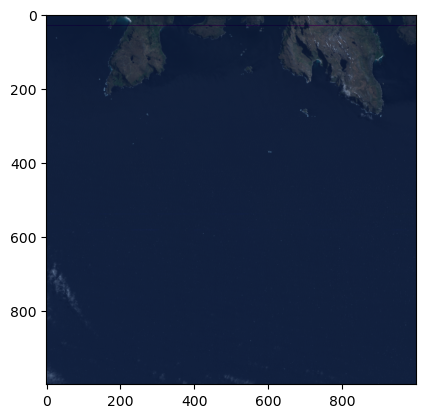

In [80]:
plt.imshow(RGB)

In [81]:
data_with_coord.shape

(1000, 1000, 68)

In [82]:
data_for_dataframe = data_with_coord.reshape(1000000, 68)

In [83]:
df = pd.DataFrame(data_for_dataframe, columns=columns)

In [84]:
df[["band_5", "lon", "lat"]]

,band_5,lon,lat
0,181.0,62.058329,5.134386
1,181.0,62.058074,5.134197
2,200.0,62.057823,5.134009
3,162.0,62.057568,5.133820
4,239.0,62.057314,5.133631
...,...,...,...
999995,154.0,61.892944,4.403368
999996,67.0,61.892693,4.403179
999997,111.0,61.892439,4.402991
999998,62.0,61.892184,4.402802


In [85]:
lat = df.lon.array
lon = df.lat.array
value = df.band_4.array
value
bands = df.columns[:-2]
bands

Index(['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7',
       'band_8', 'band_9', 'band_10', 'band_11', 'band_12', 'band_13',
       'band_14', 'band_15', 'band_16', 'band_17', 'band_18', 'band_19',
       'band_20', 'band_21', 'band_22', 'band_23', 'band_24', 'band_25',
       'band_26', 'band_27', 'band_28', 'band_29', 'band_30', 'band_31',
       'band_32', 'band_33', 'band_34', 'band_35', 'band_36', 'band_37',
       'band_38', 'band_39', 'band_40', 'band_41', 'band_42', 'band_43',
       'band_44', 'band_45', 'band_46', 'band_47', 'band_48', 'band_49',
       'band_50', 'band_51', 'band_52', 'band_53', 'band_54', 'band_55',
       'band_56', 'band_57', 'band_58', 'band_59', 'band_60', 'band_61',
       'band_62', 'band_63', 'band_64', 'band_65', 'band_66'],
      dtype='object')

C:\Users\simon\AppData\Local\Temp\ipykernel_4952\3001510383.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 10))


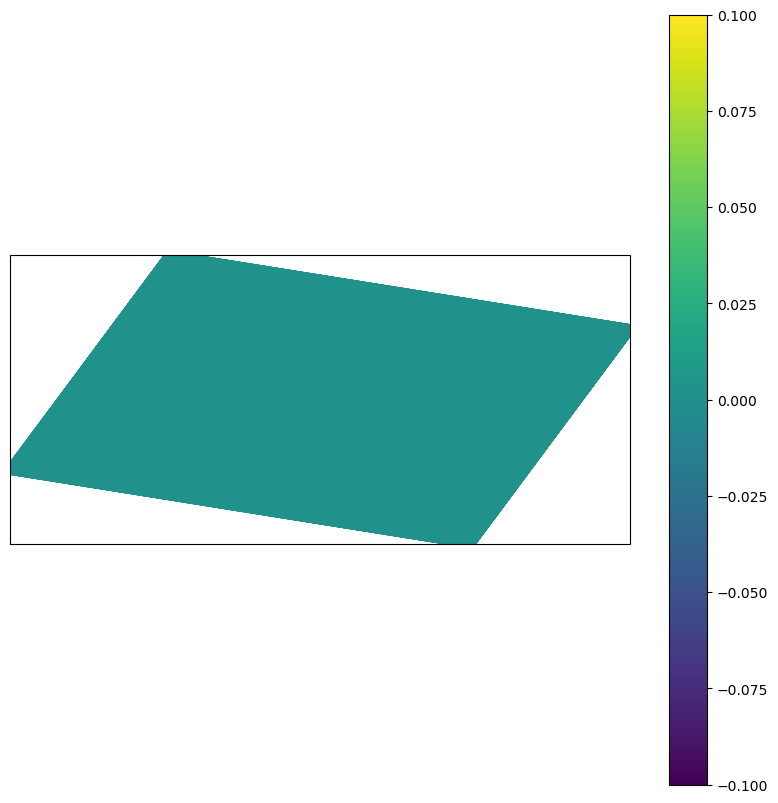

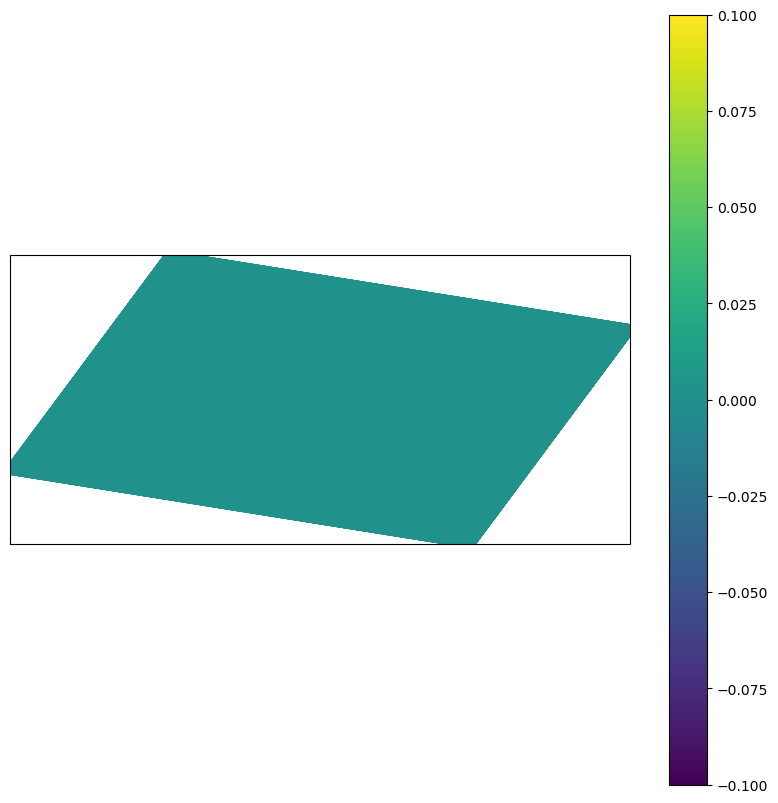

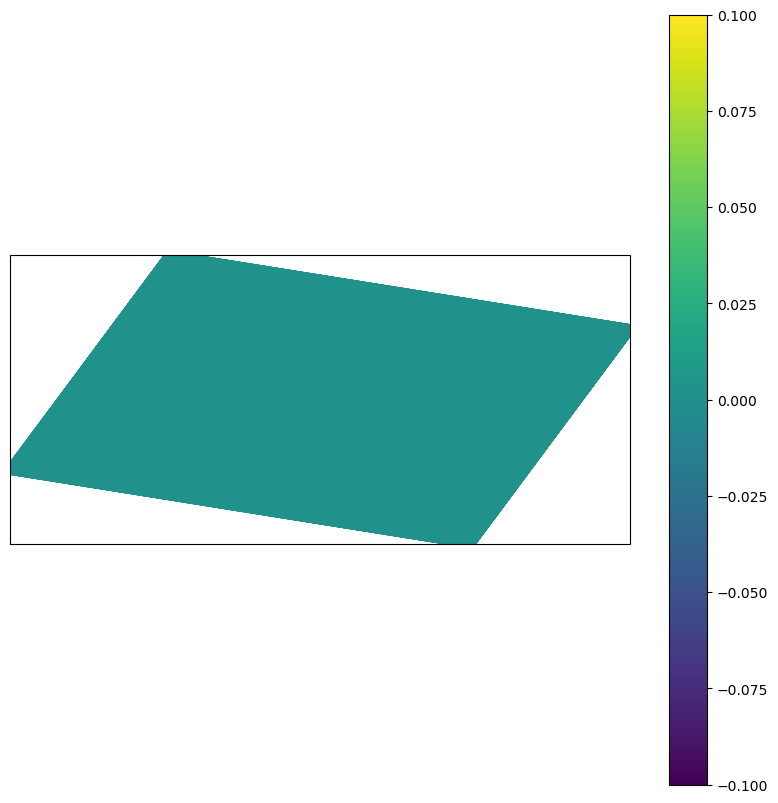

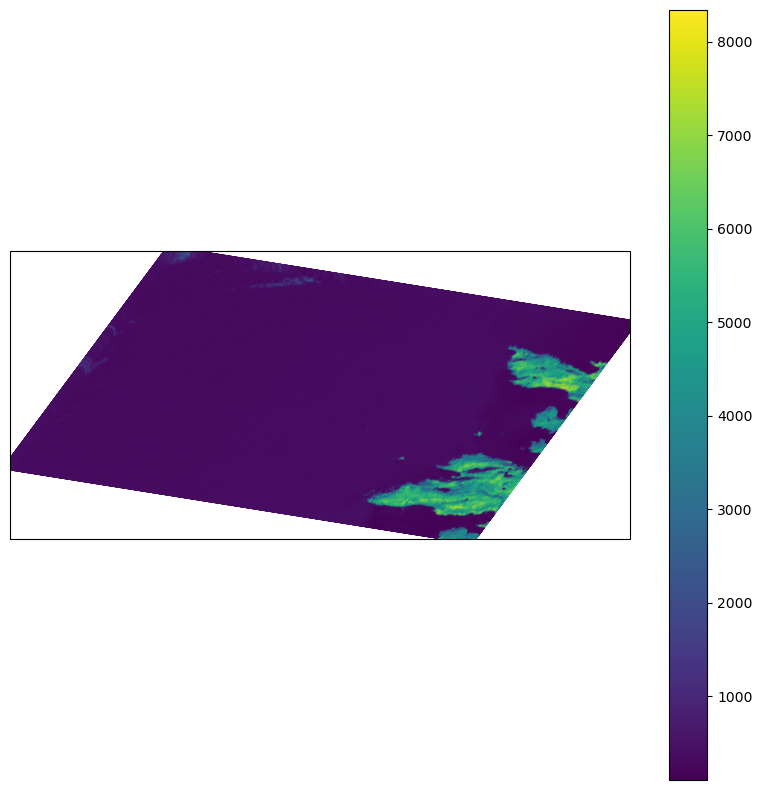

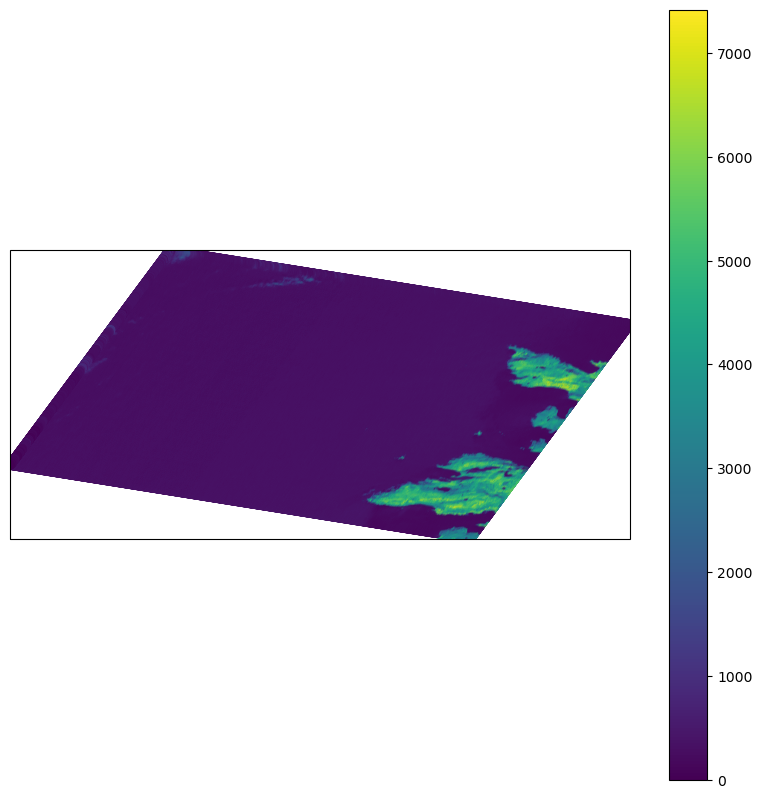

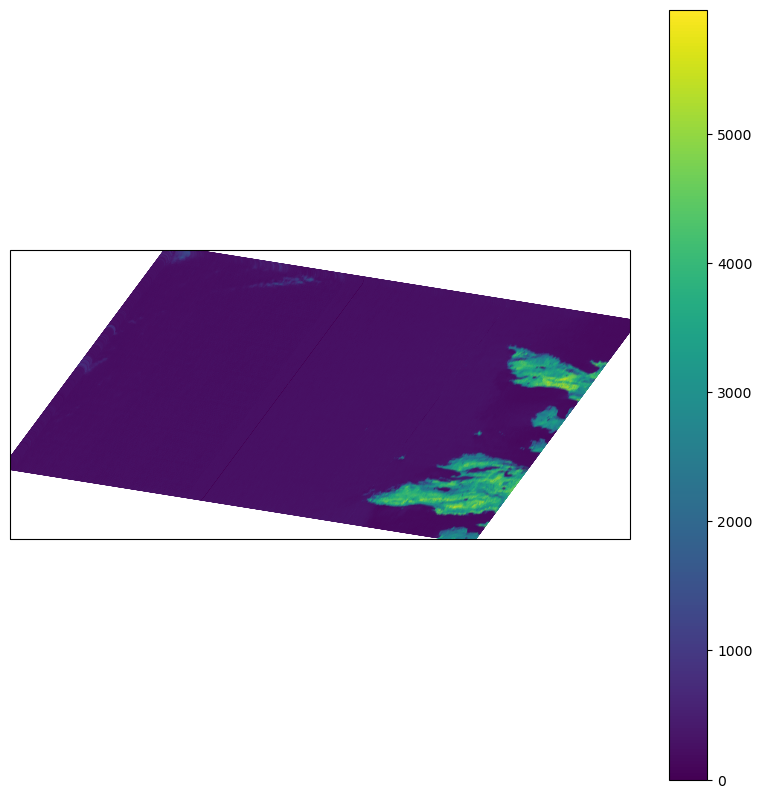

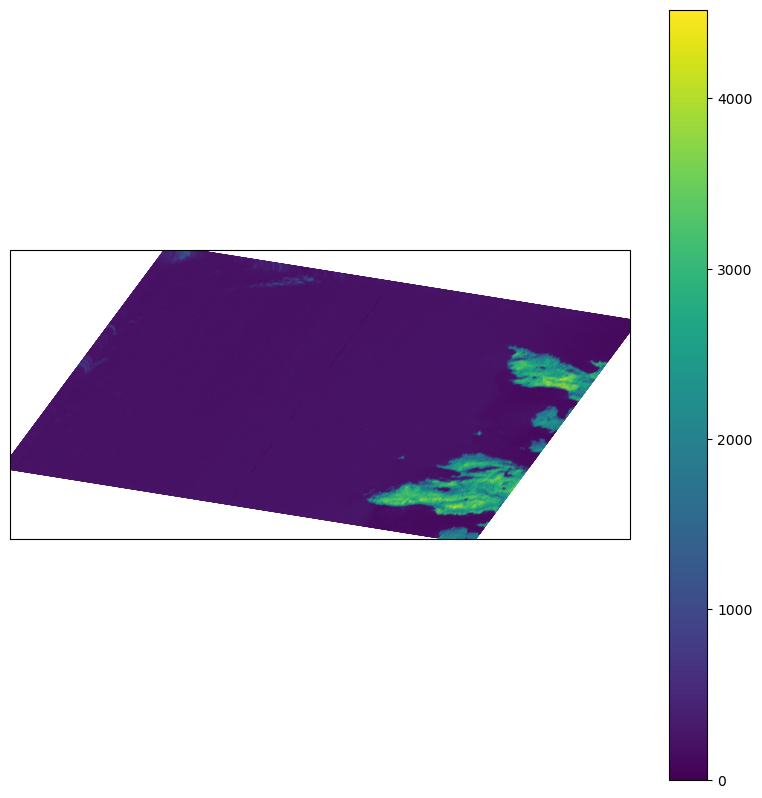

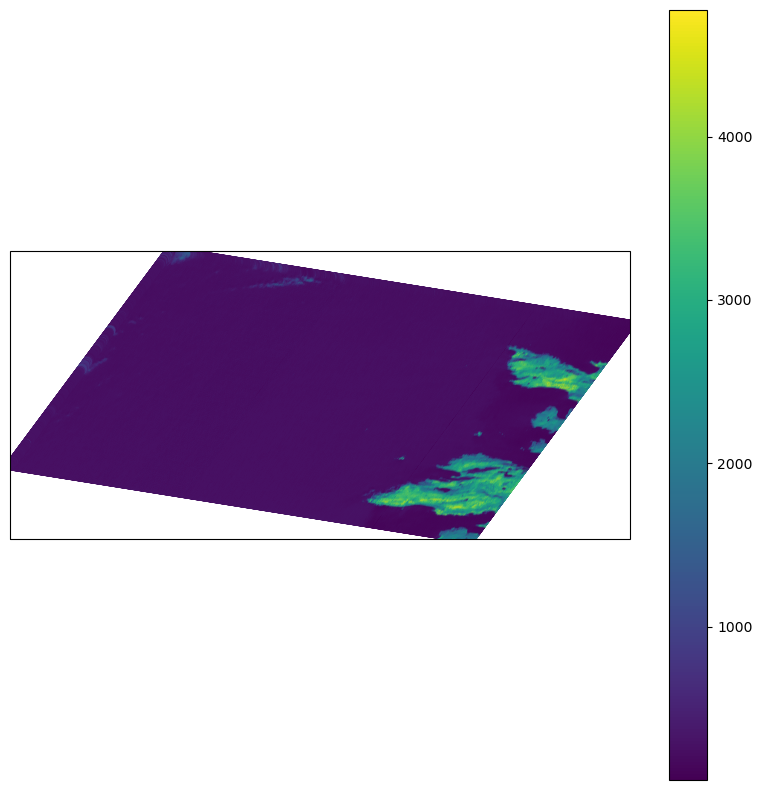

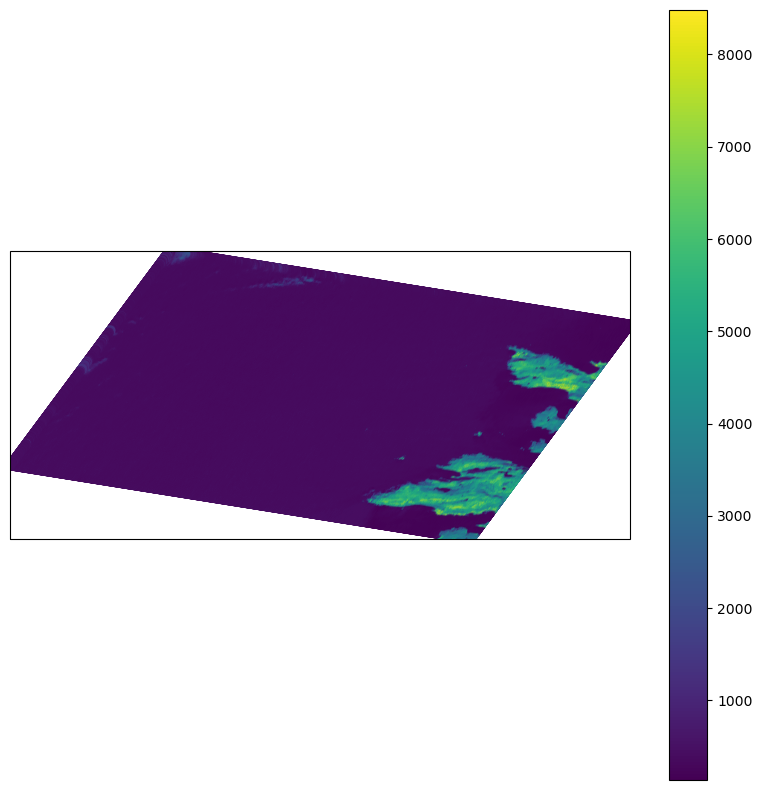

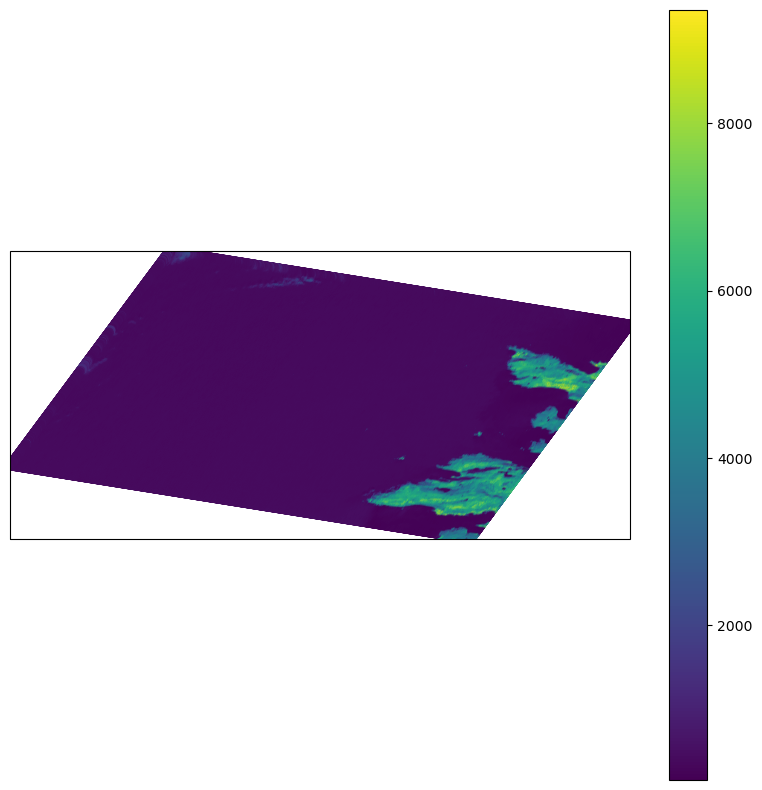

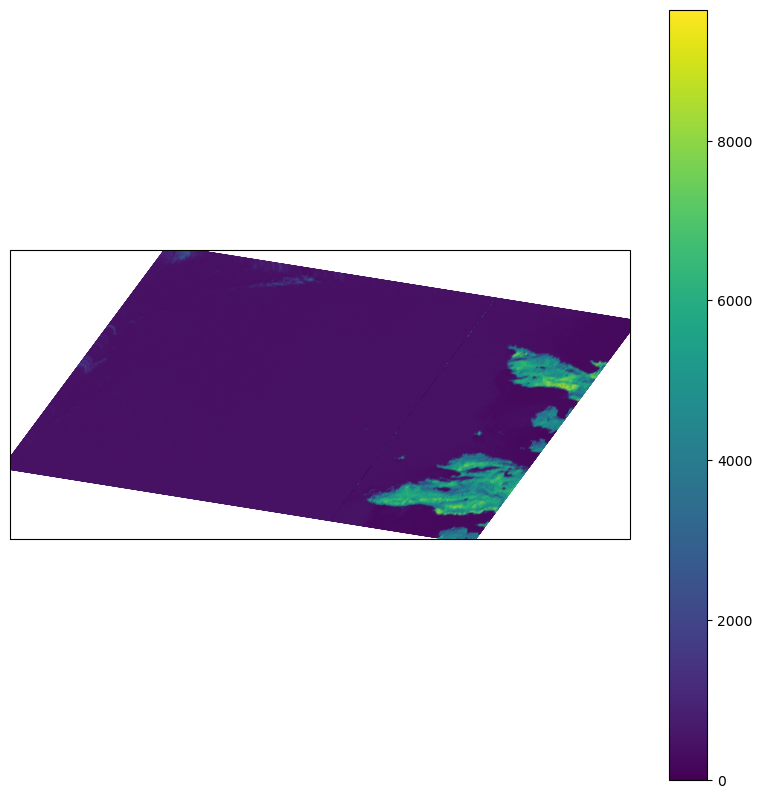

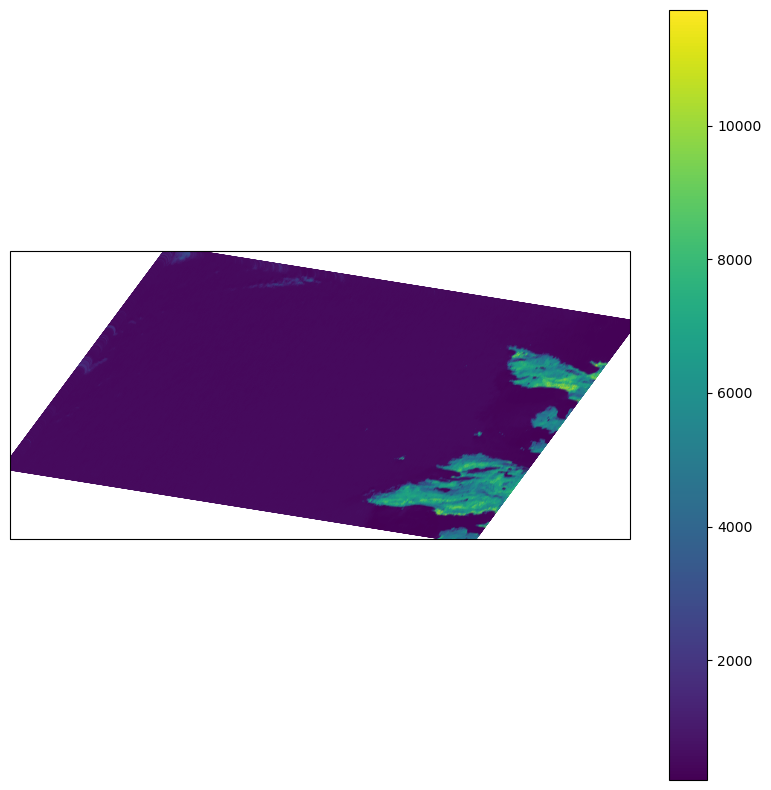

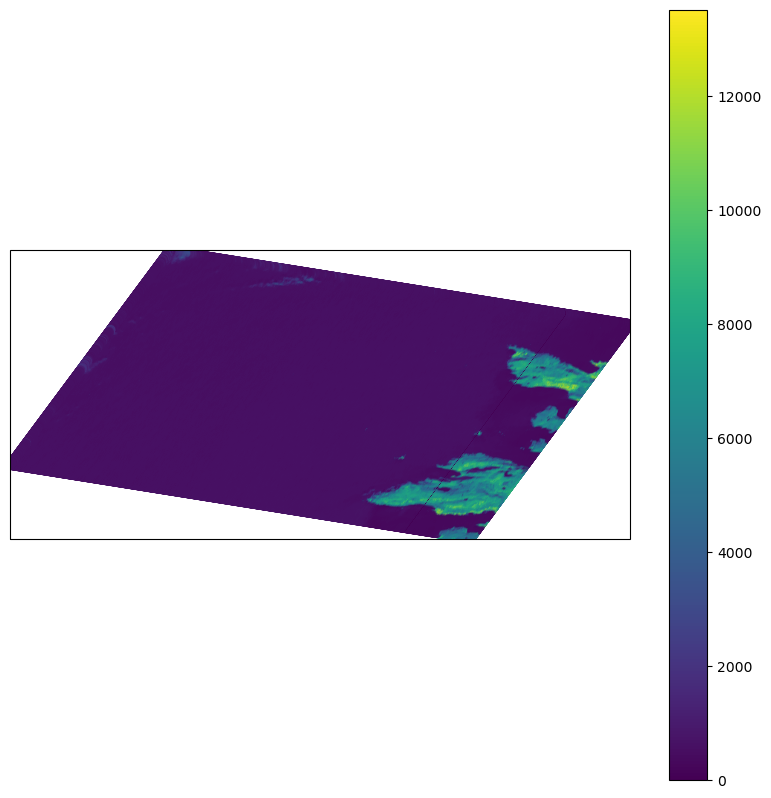

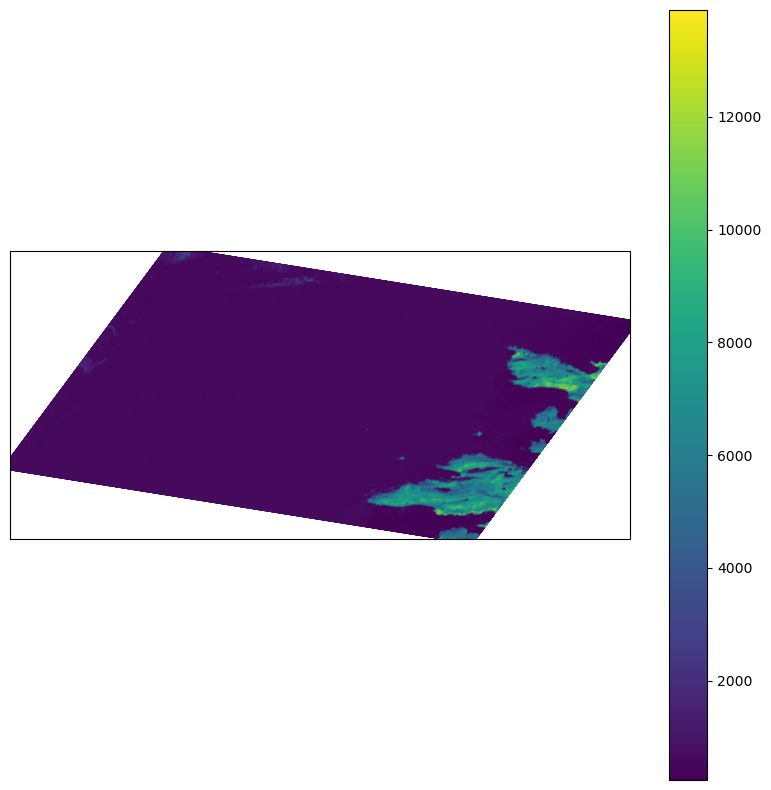

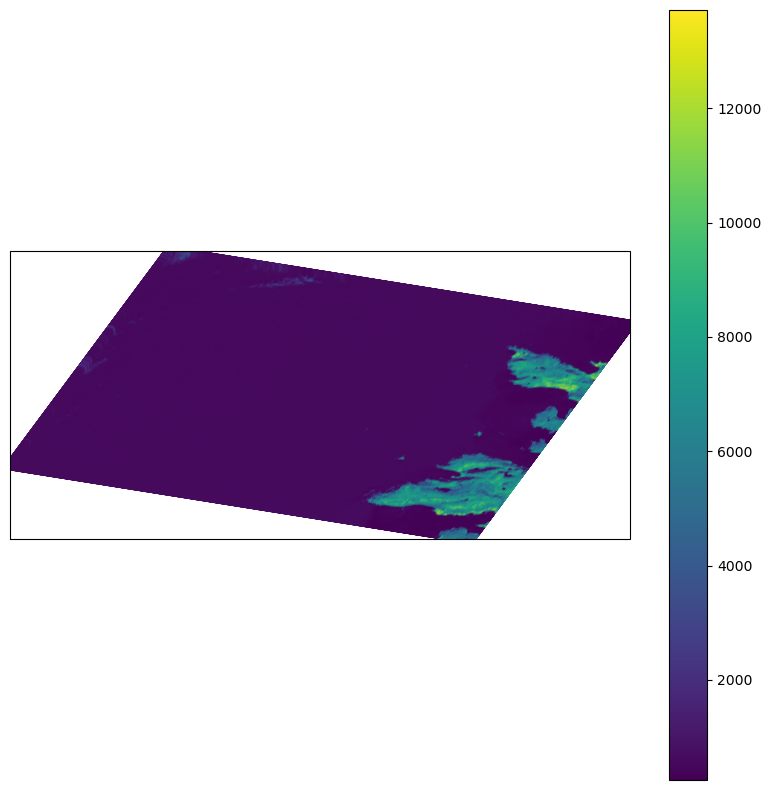

Error in callback <function flush_figures at 0x000001A3880F4280> (for post_execute):


KeyboardInterrupt: 

In [86]:
for band in bands:
    value = df[band].array

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    # Plot the map projection
    ax.set_extent([min(lon), max(lon), min(lat), max(lat)], crs=ccrs.Mercator())

    # Plot the latitude and longitude values, with the color of the marker indicating the data value
    scatter = ax.scatter(lon, lat, c=value, cmap='viridis', transform=ccrs.Mercator())

    # Add a colorbar to the plot
    plt.colorbar(scatter)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    """ ax.set_xticks(np.arange(int(min(lon)), int(max(lon)) + 1, 1))
    ax.set_yticks(np.arange(int(min(lat)), int(max(lat)) + 1, 1))
    ax.set_xticklabels(np.arange(int(min(lon)), int(max(lon)) + 1, 1))
    ax.set_yticklabels(np.arange(int(min(lat)), int(max(lat)) + 1, 1)) """
    """ ax.set_xticks(np.arange(np.min(lon), np.max(lon)+1, 0.1))
    ax.set_yticks(np.arange(np.min(lat), np.max(lat)+1, 0.1))
    ax.set_xticklabels(np.arange(np.min(lon), np.max(lon)+1, 0.1))
    ax.set_yticklabels(np.arange(np.min(lat), np.max(lat)+1, 0.1)) """

    #ax.invert_yaxis()

    # Show the plot
    plt.savefig(f"out/{band}_he4.png")
    #plt.show()

In [52]:
### Function for converting the PRISMA file to a .tiff

def prisma_2_tiff( prisma_path, tiff_output, bandforRGB = 20 ):
    # this function converts a PRISMA image to a geotiff file
    # note that it also fixes a bug in the orientation of the PRISMA image
    file1 = tab.open_file(prisma_path)
    d2 = file1.get_node("/HDFEOS/SWATHS/PRS_L1_HRC/")
    latv = np.array(d2['Geolocation Fields']['Latitude_VNIR'])
    lonv = np.array(d2['Geolocation Fields']['Longitude_VNIR'])
    vnir = d2['Data Fields']['VNIR_Cube'][:,bandforRGB,:]
    file1.close()
    
    lat_centered= latv - latv.mean()
    lat_rescaled = lat_centered / lat_centered.max()
    
    lon_centered= lonv - lonv.mean()
    lon_rescaled = lon_centered / -lon_centered.min()
    
    angle = np.arctan2(lat_rescaled, lon_rescaled, dtype=np.float32)
    
    x = np.linspace(-1, 1, 1000)
    y = np.linspace(-1, 1, 1000)
    coords = np.array(np.meshgrid(x, y), dtype=np.float32).transpose((1, 2, 0))
    
    theta = -angle[500,0] + np.pi/2
    r = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    c2 = coords @ r
    
    base_factor = np.array([lat_centered.max(), lon_centered.max()])
    fudge_factor = np.array([c2[:,:,0].max(), -c2[:,:,1].max()]) # this is done because the input lat/lon are transposed
    rescale_factor = base_factor/fudge_factor
    
    means = np.array([latv.mean(), lonv.mean()])
    
    x = np.arange(1000, dtype=np.float32)
    y = np.arange(1000, dtype=np.float32)
    coords = np.array(np.meshgrid(x, y), dtype=np.float32).transpose((1, 2, 0))
    
    to_normalized = Affine.scale(1/500, 1/500)*Affine.translation(-500, -500)
    rot = Affine.rotation(-angle[0,500]*180/np.pi )
    from_normalized = Affine.translation(*(means[::-1]))*Affine.scale(*(rescale_factor[::-1]))#*
    transform = from_normalized*rot*to_normalized
    
    lon, lat = transform * coords.transpose(2, 0, 1)
    
    with rasterio.open(
        tiff_output,
        mode="w",
        driver="GTiff",
        height=lat.shape[0],
        width=lat.shape[1],
        count=3,
        dtype=lat.dtype,
        crs="+proj=latlong",
        transform=transform,
    ) as new_dataset:
        new_dataset.write(vnir, 1)
        new_dataset.write(lat, 2)
        new_dataset.write(lon, 3)
        
    return latv.mean(), lonv.mean()

In [53]:
latv, lonv = prisma_2_tiff(filename, "prisma.tif")

In [54]:

MATCHING_CUTOFF = 0.7
SEP_CUTOFF = 0.01

In [55]:
def adjust_lat_lon(path_to_PRISMA_file, outpath=""):
    '''
    path_to_PRISMA_file - should be the full path so that re works
    '''
    zoom_level = 11
    tile_width = 7
    tile_height = 7
    
    
    metrics = {}
    print("# 1 create .tif file")
    tiff_output = outpath + '.tif'
    mean_lat, mean_lon = prisma_2_tiff(path_to_PRISMA_file, tiff_output)
    
    print("# 2 Download gmaps for the same location")
    gmd = GoogleMapDownloader(mean_lat, mean_lon, zoom_level,
                              GoogleMapsLayers.SATELLITE)
    img, tile_coords_corner = gmd.generateImage(tile_width=tile_width,
                                                tile_height=tile_height)
    
    print(" 3 Determine matched features in PRISMA image to gMaps image with SIFT")
    tif_coords, gmaps_coords, nmatches = \
        match_subblocks(tiff_output, tile_coords_corner, img, cutoff=MATCHING_CUTOFF)
    metrics['n_matches'] = nmatches
    del img
    
    orig_errs = np.sqrt(np.sum((tif_coords-gmaps_coords)**2, axis=1))
    metrics['orig_mean_error'] = orig_errs.mean()
    
    keep = orig_errs < SEP_CUTOFF
    src = np.array(tif_coords[keep])
    dst = np.array(gmaps_coords[keep])
    
    
    print(" 4 Define mapping between PRISMA LatLon and gMaps latlon")
    mapping, inliers = ransac((src, dst), AffineTransform, min_samples=4,
                               residual_threshold=0.002, max_trials=100)
    new_errs = np.sqrt(np.sum((mapping(src)-dst)**2, axis=1))
    metrics['new_mean_error'] = new_errs.mean()
    
    n_outliers = np.sum(~inliers)
    metrics['n_outliers'] = n_outliers
    
    print(" 5 Map PRISMA Latlons to gMaps latlons (ransac affine) and save for reference")
    orig = rasterio.open(tiff_output)
    adjusted_latlon = mapping(np.vstack([orig.read(2).flatten(),
                                        orig.read(3).flatten()]).transpose())
    orig.close()
    adjusted_latlon = adjusted_latlon.reshape((1000,1000,2))
    #np.savez(outpath + "_adjll.npz", adjusted_latlon = adjusted_latlon)
    np.save(outpath + ".npy", adjusted_latlon)
    return adjusted_latlon, metrics
  

In [56]:
class GoogleMapsLayers:
    ROADMAP = "v"
    TERRAIN = "p"
    ALTERED_ROADMAP = "r"
    SATELLITE = "s"
    TERRAIN_ONLY = "t"
    HYBRID = "y"

In [57]:
def pixel_to_latlon(px_x, px_y, tl_x, tl_y, zoom_level):
        """
            px_x, px_y: Pixel indices of google maps image
            tl_x, tl_y: tile indices of top left (noth-western) corner
            zoom_level: zoom level of the image

            returns: lat,lon
        """
        # background:
        # https://developers.google.com/maps/documentation/javascript/coordinates
        # https://en.wikipedia.org/wiki/Web_Mercator_projection

        tile_size = 256

        world_coord_x = (tile_size*tl_x + px_x) / 2**zoom_level
        world_coord_y = (tile_size*tl_y + px_y) / 2**zoom_level
        
        print(world_coord_x, world_coord_y)

        lon = (2.0*math.pi*world_coord_x / 256.0 - math.pi) * 180.0 / math.pi
        lat = (2.0*math.atan(math.e**math.pi * math.e**(- 2.0*math.pi*world_coord_y / 256.0)) - math.pi/2.0) * 180.0 / math.pi

        return lat,lon

In [58]:
class GoogleMapDownloader:
    """
        A class which generates high resolution google maps images given
        a longitude, latitude and zoom level
    """

    def __init__(self, lat, lng, zoom=12, layer=GoogleMapsLayers.ROADMAP):
        """
            GoogleMapDownloader Constructor
            Args:
                lat:    The latitude of the location required
                lng:    The longitude of the location required
                zoom:   The zoom level of the location required, ranges from 0 - 23
                        defaults to 12
        """
        self._lat = lat
        self._lng = lng
        self._zoom = zoom
        self._layer = layer

    def getXY(self):
        """
            Generates an X,Y tile coordinate based on the latitude, longitude
            and zoom level
            Returns:    An X,Y tile coordinate
        """

        tile_size = 256

        # Use a left shift to get the power of 2
        # i.e. a zoom level of 2 will have 2^2 = 4 tiles
        numTiles = 1 << self._zoom

        # Find the x_point given the longitude
        point_x = (tile_size / 2 + self._lng * tile_size / 360.0) * numTiles // tile_size

        # Convert the latitude to radians and take the sine
        sin_y = math.sin(self._lat * (math.pi / 180.0))

        # Calulate the y coorindate
        point_y = ((tile_size / 2) + 0.5 * math.log((1 + sin_y) / (1 - sin_y)) * -(
        tile_size / (2 * math.pi))) * numTiles // tile_size

        return int(point_x), int(point_y)


    def generateImage(self, **kwargs):
        """
            Generates an image by stitching a number of google map tiles together.
            Args:
                start_x:        The top-left x-tile coordinate
                start_y:        The top-left y-tile coordinate
                tile_width:     The number of tiles wide the image should be -
                                defaults to 5
                tile_height:    The number of tiles high the image should be -
                                defaults to 5
            Returns:
                A high-resolution Goole Map image.
        """

        start_x = kwargs.get('start_x', None)
        start_y = kwargs.get('start_y', None)
        tile_width = kwargs.get('tile_width', 16)
        tile_height = kwargs.get('tile_height', 16)

        # Check that we have x and y tile coordinates
        if start_x == None or start_y == None:
            start_x, start_y = self.getXY()
        # Determine the size of the image
        width, height = 256 * tile_width, 256 * tile_height
        # Create a new image of the size require
        j = 1
        map_img = Image.new('RGB', (width, height))
        for x in range(-tile_width//2, tile_width//2 + 1):
            for y in range(-tile_height//2, tile_height//2 +1):
                url = f'https://mt0.google.com/vt?lyrs={self._layer}&x=' + str(start_x + x) + \
                       '&y=' + str(start_y + y) + '&z=' + str(self._zoom)
                current_tile = str(x) + '-' + str(y)
                response = requests.get(url, stream=True)
                current_tile_pseudofile = io.BytesIO(response.raw.read())
                im = Image.open(current_tile_pseudofile)
                map_img.paste(im, ((x+tile_width//2) * 256, (y+tile_height//2) * 256))
        print('Image size (pix): ', map_img.size)
        tile_coords_corner = start_x-tile_width//2, start_y-tile_height//2
        print(f'Tile coordinate top left (north-west) corner: {tile_coords_corner[0]},{tile_coords_corner[1]}')
        return map_img, (tile_coords_corner)


In [59]:
def prisma_2_tiff( prisma_path, tiff_output, bandforRGB = 30 ):
    # this function converts a PRISMA image to a geotiff file
    # note that it also fixes a bug in the orientation of the PRISMA image
    file1 = tab.open_file(prisma_path)
    d2 = file1.get_node("/HDFEOS/SWATHS/PRS_L1_HRC/")
    latv = np.array(d2['Geolocation Fields']['Latitude_VNIR'])
    lonv = np.array(d2['Geolocation Fields']['Longitude_VNIR'])
    vnir = d2['Data Fields']['VNIR_Cube'][:,bandforRGB,:]
    file1.close()
    
    lat_centered= latv - latv.mean()
    lat_rescaled = lat_centered / lat_centered.max()
    
    lon_centered= lonv - lonv.mean()
    lon_rescaled = lon_centered / -lon_centered.min()
    
    angle = np.arctan2(lat_rescaled, lon_rescaled, dtype=np.float32)
    
    x = np.linspace(-1, 1, 1000)
    y = np.linspace(-1, 1, 1000)
    coords = np.array(np.meshgrid(x, y), dtype=np.float32).transpose((1, 2, 0))
    
    theta = -angle[500,0] + np.pi/2
    r = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    c2 = coords @ r
    
    base_factor = np.array([lat_centered.max(), lon_centered.max()])
    fudge_factor = np.array([c2[:,:,0].max(), -c2[:,:,1].max()]) # this is done because the input lat/lon are transposed
    rescale_factor = base_factor/fudge_factor
    
    means = np.array([latv.mean(), lonv.mean()])
    
    x = np.arange(1000, dtype=np.float32)
    y = np.arange(1000, dtype=np.float32)
    coords = np.array(np.meshgrid(x, y), dtype=np.float32).transpose((1, 2, 0))
    
    to_normalized = Affine.scale(1/500, 1/500)*Affine.translation(-500, -500)
    rot = Affine.rotation(-angle[0,500]*180/np.pi )
    from_normalized = Affine.translation(*(means[::-1]))*Affine.scale(*(rescale_factor[::-1]))#*
    transform = from_normalized*rot*to_normalized
    
    lon, lat = transform * coords.transpose(2, 0, 1)
    
    with rasterio.open(
        tiff_output,
        mode="w",
        driver="GTiff",
        height=lat.shape[0],
        width=lat.shape[1],
        count=3,
        dtype=lat.dtype,
        crs="+proj=latlong",
        transform=transform,
    ) as new_dataset:
        new_dataset.write(vnir, 1)
        new_dataset.write(lat, 2)
        new_dataset.write(lon, 3)
        new_dataset.close()
        
    return latv.mean(), lonv.mean()


In [60]:
def latlon_to_pix(lat, lon, tl_x, tl_y, zoom_level):
    """
        lat, lon: you know
        tl_x, tl_y: tile indices of top left (noth-western) corner
        zoom_level: zoom level of the image

        returns: pixelx pixely
    """
    # background:
    # https://developers.google.com/maps/documentation/javascript/coordinates
    # https://en.wikipedia.org/wiki/Web_Mercator_projection

    tile_size = 256

    world_coord_x = 128*(lon/180+1)
    world_coord_y = (math.pi-np.log(np.tan(math.pi/360*lat+math.pi/4)))*128/(math.pi)
    
    px = 2**zoom_level*world_coord_x - tile_size*tl_x
    py = 2**zoom_level*world_coord_y - tile_size*tl_y
    #print(world_coord_x, world_coord_y)

    #lon = (2.0*math.pi*world_coord_x / 256.0 - math.pi) * 180.0 / math.pi
    #lat = (2.0*math.atan(math.e**math.pi * math.e**(- 2.0*math.pi*world_coord_y / 256.0)) - math.pi/2.0) * 180.0 / math.pi

    return px, py


In [61]:
def match_subblocks(tiff_file, tile_coords_corner, gmap_img, cutoff=MATCHING_CUTOFF):
    blocks = [[[100*i,100*(i+2)-1],[100*j,100*(j+2)-1]] for i in range(9) for j in range(9)]
    
    # get the gmaps image
    gm0 = rgb2gray(gmap_img)
    gm0 = gm0 - gm0.min()
    gm0 /= gm0.max()
    
    # open the tiff file
    orig = rasterio.open(tiff_file)
    pim = np.log(orig.read(1)) - np.log(orig.read(1)).min()
    pim /= pim.max()
    
    nmatches = []
    lla = []
    llb = []
    
    for i in tqdm.tqdm(blocks):
    # determine bounds for PRISMA sub-image
        bounds = [
            [i[0][0],i[1][0]],
            [i[0][1],i[1][0]],
            [i[0][1],i[1][1]],
            [i[0][0],i[1][1]]
        ]

        # determine relevant portion of Gmaps to compare
        def k1_ll(px, py):
            return orig.read(2)[px, py], orig.read(3)[px, py]

        def k2_ll(px, py):
            latlon = pixel_to_latlon(px,py, *tile_coords_corner ,11)
            return latlon

        pbounds = []
        for bound in bounds:
            pbounds.append(latlon_to_pix(*k1_ll(*bound), *tile_coords_corner,11))
        pbounds = np.array(pbounds)
        
        xstart, xend = int(np.floor(pbounds[:,0].min())), int(np.ceil(pbounds[:,0].max()))
        ystart, yend = int(np.floor(pbounds[:,1].min())), int(np.ceil(pbounds[:,1].max()))

        # plot the two maps side by side (and rotated!)
        #fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        #ax[0].imshow(pim[i[0][0]:i[0][1],i[1][0]:i[1][1]])
        #ax[1].imshow(np.rot90(gm0[ystart:yend,xstart:xend]))
        #plt.show()

        # extract descriptors for matching images
        descriptor_extractor = SIFT()
        try: #to deal with runtime errors which can be generated by SIFT
            descriptor_extractor.detect_and_extract(pim[i[0][0]:i[0][1],i[1][0]:i[1][1]])
            keypoints1 = descriptor_extractor.keypoints
            descriptors1 = descriptor_extractor.descriptors
            descriptor_extractor.detect_and_extract((gm0[ystart:yend,xstart:xend]))
            keypoints2 = descriptor_extractor.keypoints
            descriptors2 = descriptor_extractor.descriptors

            matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=cutoff,
                                  cross_check=True)
            
            
            #print("{} matches!".format(len(matches12)))

            # define local distance metrics
            def k2_ll(px, py):
                # not sure why the x and y coordinates switch here
                latlon = pixel_to_latlon(py + xstart ,px + ystart,
                                         *tile_coords_corner ,11)
                return latlon

            def k1_ll(px, py):
                px = px + i[0][0]
                py = py + i[1][0]
                return orig.read(2)[px, py], orig.read(3)[px, py]

            # check to see how close the points are in lat/lon, should usually have .00x accuracy

            for pair in matches12:
                ll1 = k1_ll(*keypoints1[pair[0]])
                lla.append(ll1)
                ll2 = k2_ll(*keypoints2[pair[1]])
                llb.append(ll2)

            nmatches.append(len(matches12))
        except RuntimeError:
            pass
        
    lla = np.array(lla)
    llb = np.array(llb)
    return lla, llb, nmatches    

In [62]:
prisma_path = "HyperSpectral4.he5"
prisma_path = dir_path + "/" + prisma_path
outpath = "out/out3"

adjusted = adjust_lat_lon(prisma_path, outpath)


# 1 create .tif file
# 2 Download gmaps for the same location
Image size (pix):  (1792, 1792)
Tile coordinate top left (north-west) corner: 1048,568
 3 Determine matched features in PRISMA image to gMaps image with SIFT


  1%|          | 1/81 [00:00<00:28,  2.81it/s]

131.58349609375 71.3740234375
131.62255859375 71.380859375


  2%|▏         | 2/81 [00:01<00:47,  1.66it/s]

131.55712890625 71.4267578125
131.58349609375 71.3740234375
131.5693359375 71.40869140625
131.56884765625 71.392578125
131.59814453125 71.39697265625
131.56689453125 71.41015625
131.56005859375 71.40869140625
131.60888671875 71.40087890625
131.6142578125 71.4140625
131.62255859375 71.380859375
131.5986328125 71.400390625
131.56884765625 71.392578125
131.5732421875 71.392578125
131.56005859375 71.40869140625


  4%|▎         | 3/81 [00:01<00:49,  1.58it/s]

131.6025390625 71.3955078125
131.5693359375 71.40869140625
131.56884765625 71.392578125
131.59814453125 71.39697265625
131.56689453125 71.41015625
131.56005859375 71.40869140625
131.61083984375 71.392578125
131.6142578125 71.4140625
131.5810546875 71.46435546875
131.5986328125 71.400390625
131.56884765625 71.392578125
131.5732421875 71.392578125
131.56005859375 71.40869140625


  5%|▍         | 4/81 [00:02<00:44,  1.73it/s]

131.58544921875 71.48291015625
131.57666015625 71.50146484375
131.5732421875 71.47119140625
131.5654296875 71.49365234375
131.5712890625 71.49951171875
131.59033203125 71.478515625
131.57373046875 71.5009765625
131.5810546875 71.46435546875


  6%|▌         | 5/81 [00:02<00:47,  1.61it/s]

131.5673828125 71.54443359375
131.57861328125 71.5087890625
131.58544921875 71.48291015625
131.5693359375 71.52392578125
131.57666015625 71.50146484375
131.57958984375 71.484375
131.55859375 71.53759765625
131.5654296875 71.49365234375
131.52197265625 71.5126953125
131.517578125 71.51123046875
131.56005859375 71.53662109375
131.5712890625 71.49951171875
131.58984375 71.47900390625
131.576171875 71.50439453125
131.57373046875 71.5009765625
131.57861328125 71.486328125
131.57861328125 71.48095703125
131.55615234375 71.5361328125
131.5380859375 71.50732421875


  7%|▋         | 6/81 [00:04<00:57,  1.30it/s]

131.5693359375 71.52392578125
131.548828125 71.5732421875
131.55859375 71.53759765625
131.5419921875 71.58056640625
131.54931640625 71.5615234375
131.54248046875 71.5771484375
131.529296875 71.57421875
131.5263671875 71.5537109375
131.525390625 71.55078125
131.52197265625 71.5126953125
131.5205078125 71.51318359375
131.50537109375 71.55322265625
131.517578125 71.51123046875
131.5576171875 71.57275390625
131.54833984375 71.57666015625
131.56005859375 71.53662109375
131.5390625 71.578125
131.51513671875 71.55126953125
131.529296875 71.572265625
131.55615234375 71.5361328125
131.5283203125 71.55078125
131.53759765625 71.56689453125
131.50830078125 71.54833984375
131.53955078125 71.61669921875
131.54931640625 71.58447265625
131.548828125 71.5732421875
131.54541015625 71.58251953125
131.5419921875 71.58056640625
131.54052734375 71.58447265625
131.54931640625 71.5615234375
131.54248046875 71.5771484375
131.529296875 71.57421875
131.51953125 71.58837890625
131.5185546875 71.5869140625
131.518

  9%|▊         | 7/81 [00:05<01:02,  1.18it/s]

131.4912109375 71.5908203125
131.54443359375 71.5849609375
131.53759765625 71.56689453125
131.529296875 71.572265625
131.53955078125 71.61669921875
131.51904296875 71.654296875
131.54052734375 71.58447265625
131.51953125 71.58837890625
131.5185546875 71.5869140625
131.51806640625 71.580078125
131.50634765625 71.603515625
131.50927734375 71.59326171875
131.5107421875 71.58056640625
131.50537109375 71.59521484375
131.509765625 71.57861328125
131.51611328125 71.5712890625
131.49462890625 71.6064453125
131.48486328125 71.60498046875
131.49072265625 71.5888671875
131.48779296875 71.59619140625
131.48291015625 71.60888671875
131.48095703125 71.6083984375
131.5361328125 71.654296875
131.4912109375 71.5693359375
131.50048828125 71.65576171875
131.47509765625 71.599609375
131.47607421875 71.59228515625
131.5380859375 71.61962890625
131.5380859375 71.61376953125
131.52490234375 71.61474609375
131.51611328125 71.58837890625
131.513671875 71.5869140625
131.5126953125 71.58203125
131.5048828125 71.

 10%|▉         | 8/81 [00:06<01:06,  1.09it/s]

131.48779296875 71.56982421875
131.50927734375 71.58984375
131.49169921875 71.6103515625
131.48876953125 71.59375
131.4833984375 71.59033203125
131.50830078125 71.62060546875
131.4912109375 71.5908203125
131.48291015625 71.60888671875
131.50830078125 71.62060546875


 11%|█         | 9/81 [00:06<01:03,  1.13it/s]

131.5361328125 71.654296875
131.51904296875 71.6728515625
131.51025390625 71.689453125
131.51025390625 71.6865234375
131.51904296875 71.654296875
131.48779296875 71.65576171875
131.48388671875 71.65283203125
131.48291015625 71.60888671875
131.45654296875 71.64404296875
131.51220703125 71.68603515625
131.513671875 71.65380859375
131.5029296875 71.6572265625
131.52783203125 71.6796875
131.521484375 71.673828125
131.51416015625 71.66748046875
131.51904296875 71.6728515625
131.48291015625 71.60888671875
131.513671875 71.65380859375


 12%|█▏        | 10/81 [00:07<00:49,  1.44it/s]

131.58349609375 71.3740234375
131.54833984375 71.35302734375
131.54638671875 71.35888671875


 14%|█▎        | 11/81 [00:07<00:42,  1.67it/s]

131.58349609375 71.3740234375
131.56884765625 71.392578125
131.54833984375 71.35302734375
131.56689453125 71.41015625
131.56005859375 71.40869140625
131.54638671875 71.35888671875
131.5498046875 71.3720703125
131.56884765625 71.392578125
131.5732421875 71.392578125
131.56005859375 71.40869140625


 15%|█▍        | 12/81 [00:07<00:36,  1.88it/s]

131.5693359375 71.40869140625
131.55712890625 71.4267578125
131.56884765625 71.392578125
131.56689453125 71.41015625
131.56005859375 71.40869140625
131.56884765625 71.392578125
131.5732421875 71.392578125
131.56005859375 71.40869140625


 16%|█▌        | 13/81 [00:08<00:31,  2.14it/s]

131.56982421875 71.427734375
131.55712890625 71.4267578125


 17%|█▋        | 14/81 [00:08<00:26,  2.50it/s]

131.52197265625 71.5126953125
131.5302734375 71.48583984375
131.5205078125 71.51318359375
131.517578125 71.51123046875


 19%|█▊        | 15/81 [00:08<00:26,  2.53it/s]

131.52197265625 71.5126953125
131.5234375 71.54638671875
131.50537109375 71.55322265625
131.517578125 71.51123046875
131.51513671875 71.55126953125
131.50830078125 71.54833984375


 20%|█▉        | 16/81 [00:09<00:31,  2.03it/s]

131.50634765625 71.603515625
131.50927734375 71.59326171875
131.5068359375 71.595703125
131.5107421875 71.58056640625
131.50537109375 71.59521484375
131.51171875 71.5751953125
131.509765625 71.57861328125
131.49462890625 71.6064453125
131.50537109375 71.55322265625
131.4912109375 71.5908203125
131.49072265625 71.5888671875
131.48779296875 71.59619140625
131.4912109375 71.5693359375
131.47607421875 71.59228515625
131.5205078125 71.51318359375
131.5048828125 71.59765625
131.5029296875 71.5869140625
131.4951171875 71.595703125
131.48828125 71.58935546875
131.49072265625 71.5673828125
131.48828125 71.57275390625
131.48779296875 71.56982421875
131.45361328125 71.55224609375
131.48876953125 71.59375
131.4833984375 71.59033203125
131.4970703125 71.57958984375
131.4912109375 71.5908203125
131.50830078125 71.54833984375
131.45556640625 71.5537109375


 21%|██        | 17/81 [00:10<00:41,  1.54it/s]

131.50634765625 71.603515625
131.50927734375 71.59326171875
131.5107421875 71.58056640625
131.50537109375 71.59521484375
131.509765625 71.57861328125
131.49462890625 71.6064453125
131.4912109375 71.5908203125
131.48486328125 71.60498046875
131.49072265625 71.5888671875
131.48779296875 71.59619140625
131.48291015625 71.60888671875
131.48095703125 71.6083984375
131.4912109375 71.5693359375
131.46533203125 71.63671875
131.47509765625 71.599609375
131.47607421875 71.59228515625
131.44677734375 71.607421875
131.5048828125 71.59765625
131.49462890625 71.61474609375
131.4951171875 71.595703125
131.48779296875 71.6064453125
131.4853515625 71.60693359375
131.48828125 71.58935546875
131.48828125 71.57275390625
131.48779296875 71.56982421875
131.4482421875 71.60595703125
131.44580078125 71.6123046875
131.49169921875 71.6103515625
131.48876953125 71.59375
131.48388671875 71.59033203125
131.4873046875 71.60009765625
131.4912109375 71.5908203125
131.48291015625 71.60888671875
131.44775390625 71.6103

 22%|██▏       | 18/81 [00:11<00:39,  1.60it/s]

131.48779296875 71.65576171875
131.48388671875 71.65283203125
131.48291015625 71.60888671875
131.46533203125 71.63671875
131.45654296875 71.64404296875
131.4443359375 71.63916015625
131.44677734375 71.607421875
131.43505859375 71.63623046875
131.49462890625 71.61474609375
131.4482421875 71.60595703125
131.44580078125 71.6123046875
131.48291015625 71.60888671875
131.44775390625 71.6103515625
131.44775390625 71.6083984375


 25%|██▍       | 20/81 [00:11<00:24,  2.46it/s]

131.54833984375 71.35302734375
131.54638671875 71.35888671875
131.54833984375 71.35302734375


 30%|██▉       | 24/81 [00:12<00:12,  4.57it/s]

131.45361328125 71.55224609375


 31%|███       | 25/81 [00:12<00:14,  3.93it/s]

131.4560546875 71.55126953125
131.45361328125 71.55224609375
131.45556640625 71.5537109375


 32%|███▏      | 26/81 [00:12<00:16,  3.39it/s]

131.44677734375 71.607421875
131.4482421875 71.60595703125
131.44580078125 71.6123046875
131.4287109375 71.63330078125
131.44775390625 71.6103515625
131.44775390625 71.6083984375


 36%|███▌      | 29/81 [00:13<00:10,  4.91it/s]

131.44580078125 71.638671875
131.4443359375 71.63916015625
131.44677734375 71.607421875
131.43505859375 71.63623046875
131.4443359375 71.60986328125
131.4287109375 71.63330078125
131.42822265625 71.63134765625
131.4482421875 71.60595703125
131.44580078125 71.6123046875
131.44775390625 71.6103515625
131.44775390625 71.6083984375
131.45654296875 71.64404296875


 43%|████▎     | 35/81 [00:13<00:05,  7.87it/s]

131.45361328125 71.55224609375


 47%|████▋     | 38/81 [00:14<00:05,  7.95it/s]

131.46728515625 71.25244140625


 85%|████████▌ | 69/81 [00:17<00:01,  6.77it/s]

131.2646484375 71.39697265625


 96%|█████████▋| 78/81 [00:19<00:00,  6.72it/s]

131.2646484375 71.39697265625


100%|██████████| 81/81 [00:19<00:00,  4.15it/s]


 4 Define mapping between PRISMA LatLon and gMaps latlon
 5 Map PRISMA Latlons to gMaps latlons (ransac affine) and save for reference


In [63]:
adjusted[0].shape

(1000, 1000, 2)

In [64]:
np.save("out/out4.npy", adjusted[0])

In [65]:
#adjusted = np.load("out_adjll.npz")
adjusted = np.load('out/out4.npy')
adjusted.shape


(1000, 1000, 2)

In [70]:
from rasterio.plot import show
with rasterio.open("out/out4.tif") as src:
    fig, ax = plt.subplots()

    # transform rasterio plot to real world coords
    extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')
    src.close()

RasterioIOError: 'out/out4.tif' not recognized as a supported file format.

In [ ]:
data_with_coord[:,:,66:] = adjusted